In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from matplotlib import patches

%matplotlib inline


In [3]:
train_root = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/train'
valid_root = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/valid'#r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/valid'
gt_root = r"/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/df_ground_truth.csv"
dummy_root = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/trial'

In [4]:
df = pd.read_csv(gt_root)
df.head()

,id,folder_id,study_id,width,height,xmin,ymin,xmax,ymax,class
0,000a312787f2_image,81456c9c5423,5776db0cec75,3488,4256,95,85,218,367,opacity
1,000a312787f2_image,81456c9c5423,5776db0cec75,3488,4256,270,87,402,345,opacity
2,0012ff7358bc_image,22897cd1daa0,9d514ce429a7,2544,3056,113,40,259,241,opacity
3,0012ff7358bc_image,22897cd1daa0,9d514ce429a7,2544,3056,300,81,404,323,opacity
4,001398f4ff4f_image,4d47bc042ee6,28dddc8559b2,3520,4280,326,317,440,405,opacity


In [ ]:
#df.loc[df["id"] == "0012ff7358bc_image", "class"].iloc[0]== "none"

In [5]:
df_test = pd.DataFrame(columns=df.columns)
df_test.head()

,id,folder_id,study_id,width,height,xmin,ymin,xmax,ymax,class


In [6]:
for dirname,_,filenames in os.walk(valid_root): #valid_root):
  for filename in filenames:
    name = filename.split(".")[0]
    rows = df.loc[df["id"] == name, :]
    df_test = df_test.append(rows, ignore_index=True)
    df.drop(rows.index, inplace=True)

In [7]:
print(len(df), len(df_test))

7903 1990


In [8]:
print(torch.__version__)

1.9.0+cu102


In [ ]:
import sys
sys.version

'3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]'

**Define custom dataset class**

In [9]:
class MarkDataset(torch.utils.data.Dataset):
    def __init__(self, root, gt, transforms=None):
        '''
        root: root directory to images. can either be train or valid sets
        gt_root: directory to ground truth csv file. ground truths expect each row to contain a different detection
        is_train: if true, will load training set, if false, loads validation set

        '''
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        # if is_train:
        #   self.imgs = list(sorted(os.listdir(os.path.join(root, "train"))))
        # else:
        #   self.imgs = list(sorted(os.listdir(os.path.join(root, "valid"))))
        self.imgs = list(sorted(os.listdir(root)))
        self.gt = gt #pd.read_csv(gt_root)#list(sorted(os.listdir(os.path.join(root, "Annotations"))))
 
    def __getitem__(self, idx):
        '''
        given an image idx number, will gather ground truth data and put it into a dictionary of that image
        '''
        # load images and bbox
        
        img_path = os.path.join(self.root, self.imgs[idx])
        #bbox_xml_path = os.path.join(self.root, "Annotations", self.bbox_xml[idx])
        annotations = self.gt #pd.read_csv("/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/df_ground_truth.csv")
        img = Image.open(img_path).convert("RGB")        
        imgname = self.imgs[idx].split('.')[0]
        # Read file, VOC format dataset label is xml format file
        #dom = parse(bbox_xml_path)
        # Get Document Element Object
        #data = dom.documentElement
        # Get objects
        #objects = bbox_xml.loc#data.getElementsByTagName('object')        
        # get bounding box coordinates
        objects =  annotations.loc[annotations.id == imgname]####################################
        boxes = []
        labels = []
        detected = True
        for _,row in objects[objects.id == imgname].iterrows():
            
            if row["class"] == "opacity":
              labels.append(1) # Background label is 0, opacity label is 
              xmin = row.xmin
              xmax = row.xmax
              ymin = row.ymin
              ymax = row.ymax
              boxes.append([xmin, ymin, xmax, ymax])
            else:
              detected= False
              #labels.append(0)
         
              boxes = torch.zeros((0, 4), dtype=torch.float32)
            
        # for object_ in objects:
        #     # Get the contents of the label
        #     name = object_.getElementsByTagName('name')[0].childNodes[0].nodeValue  # Is label, mark_type_1 or mark_type_2
        #     labels.append(np.int(name[-1]))  # Background label is 0, mark_type_1 and mark_type_2 labels are 1 and 2, respectively
            
        #     bndbox = object_.getElementsByTagName('bndbox')[0]
        #     xmin = np.float(bndbox.getElementsByTagName('xmin')[0].childNodes[0].nodeValue)
        #     ymin = np.float(bndbox.getElementsByTagName('ymin')[0].childNodes[0].nodeValue)
        #     xmax = np.float(bndbox.getElementsByTagName('xmax')[0].childNodes[0].nodeValue)
        #     ymax = np.float(bndbox.getElementsByTagName('ymax')[0].childNodes[0].nodeValue)
        #     boxes.append([xmin, ymin, xmax, ymax])        
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        #area =  torch.tensor([])
        area = 0
        if detected == True:
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

              # suppose all instances are not crowd
        iscrowd = torch.zeros((objects.shape[0],), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # Since you are training a target detection network, there is no target [masks] = masks in the tutorial
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

**Train model (transfer learning approach with pretrained ResNet50v2 base)**

In [ ]:
#!git clone https://github.com/pytorch/vision

Cloning into 'vision'...
remote: Enumerating objects: 30358, done.
remote: Counting objects: 100% (2901/2901), done.
remote: Compressing objects: 100% (708/708), done.
remote: Total 30358 (delta 2214), reused 2774 (delta 2136), pack-reused 27457
Receiving objects: 100% (30358/30358), 38.23 MiB | 24.67 MiB/s, done.
Resolving deltas: 100% (22830/22830), done.


In [10]:
#%cd /content/vision/references/detection
%cd /content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/vision/vision-master/references/detection

/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/vision/vision-master/references/detection


Define augmentations 

In [11]:
###loads data
import utils
import transforms as T
from engine import train_one_epoch, evaluate
# utils, transforms, engine were just downloadedUtils.py,transforms.py,engine.py
 ###Don't worry about augmentations yet
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        
        transforms.append(T.RandomIoUCrop(min_scale = 0.8, max_scale= 1.0, min_aspect_ratio= 1.0,max_aspect_ratio= 1.0 ))
        #transforms.append(T.RandomZoomOut(side_range= (1.0, 1.25)))

        transforms.append(T.RandomPhotometricDistort(contrast = (0.2, 1.5),brightness= (0.5, 1.5) ))
        # 50% chance of flipping horizontally
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

Here we load the data into our defined dataset class

In [12]:


train_root = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/train'
valid_root = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/valid'#r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/valid'
#valid_root = dummy_root
#gt_root = r"/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/df_ground_truth.csv"
# train on the GPU or on the CPU, if a GPU is not available
to_save = '/content/drive/Shareddrives/COVID-19_X-Ray/Retinanet/RetinaNet_sweep_models' # "/content/drive/Shareddrives/COVID-19_X-Ray/Retinanet/RetinaNet_models"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 2 classes, opacity，background
num_classes = 2
# use our dataset and defined transformations
dataset = MarkDataset(train_root, df, get_transform(train=True))
dataset_test = MarkDataset(valid_root, df_test, get_transform(train=False))

# split the dataset in train and test set
# My dataset has 492 diagrams, almost training validation 4:1
indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-100])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
# Num_when training models in jupyter notebook The workers parameter can only be 0, otherwise an error will occur, which is commented out here
'''
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, # num_workers=4,   ######batch size 32 causes memory error when training
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False, # num_workers=4,
    collate_fn=utils.collate_fn)
'''

'\ndata_loader = torch.utils.data.DataLoader(\n    dataset, batch_size=16, shuffle=True, # num_workers=4,   ######batch size 32 causes memory error when training\n    collate_fn=utils.collate_fn)\n\ndata_loader_test = torch.utils.data.DataLoader(\n    dataset_test, batch_size=16, shuffle=False, # num_workers=4,\n    collate_fn=utils.collate_fn)\n'

load base Retinaet model

In [ ]:
# get the model using our helper function
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)#, trainable_backbone_layers=0)  # Or get_object_detection_model(num_classes)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)#(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)
#model = trainable_backbone_layers=3
#torchvision.models.detection.retinanet_resnet50_fpn
# move model to the right device
model.to(device)

In [ ]:
for k, v in model.named_parameters():
  print('{}: {}'.format(k, v.requires_grad))

Configure the model training and optimizer. WITH NEW TRAIN FUNCTON< RUNNING IS OPTIONAL

In [16]:
##### Configure model
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

# SGD
#optimizer = torch.optim.Adam(params, lr = 0.0001)

# optimizer = torch.optim.SGD(params, lr=0.0005,
#                            momentum=0.9) #weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.001,
#                                weight_decay= 1e-4)  #lr was 0.0005 before, et's try 0.001 again                      

# and a learning rate scheduler
# cos learning rate
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# let's train it for   epochs
#num_epochs = 80 ###########################hkjh#CHANGE

For logging and tracking training using Weights and Biases API

In [17]:
%pip install -q wandb

     |████████████████████████████████| 1.8 MB 40.5 MB/s 
     |████████████████████████████████| 138 kB 70.6 MB/s 
     |████████████████████████████████| 97 kB 9.0 MB/s 
     |████████████████████████████████| 133 kB 66.7 MB/s 
     |████████████████████████████████| 170 kB 69.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [19]:
import wandb
wandb.login()

# 1. Start a new run
wandb.init(name='train_run',project='RetinaNet_Sweep', entity='andy245liu')#,resume=True) #change entity to your wandb username. you need to be logged into that account



# 2. Save model inputs and hyperparameters
#config = wandb.config
#config.learning_rate = 1e-3

# 3. Log gradients and model parameters
#######################################################wandb.watch(model)
# for batch_idx, (data, target) in enumerate(train_loader):
#   ...
#   if batch_idx % args.log_interval == 0:
#     # 4. Log metrics to visualize performance
#     wandb.log({"loss": loss})


##################To view the logging and training visualization, click on the link "Run page" that will appear below once you paste your wandb API code
  

wandb: Currently logged in as: andy245liu (use `wandb login --relogin` to force relogin)


In [35]:
metric = {
    'name': 'validation_loss',
    'goal': 'minimize'   
    }
sweep_config = {
  "name" : "retina_sweep",
  "method" : "bayes",
  "parameters" : {
    "epochs" : {
      "values" : [20,30, 50, 80]
    },
    "learning_rate" :{
      'values' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
      #"min": 0.0001,
      #"max": 0.1
    },
    'batch_size': {
        
        "values" : [2, 8, 16]
      },
     'optimizer': {
        'values': ['adam', 'sgd']
        }
  }
}
sweep_config['metric'] = metric
sweep_id = wandb.sweep(sweep_config, project= 'RetinaNet_Sweep', entity='andy245liu')

Create sweep with ID: q265xetj
Sweep URL: https://wandb.ai/andy245liu/RetinaNet_Sweep/sweeps/q265xetj


In [37]:
def build_dataloader(batch_size):
   
    data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, # num_workers=4,   ######batch size 32 causes memory error when training
    collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=batch_size, shuffle=False, # num_workers=4,
        collate_fn=utils.collate_fn)

    return data_loader, data_loader_test

        

def build_optimizer( optimizer, learning_rate, params):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(params,
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(params,
                               lr=learning_rate)
    return optimizer

In [40]:
def train(config=None):
  with wandb.init(config=config):
    config = wandb.config
    #params = [p for p in model.parameters() if p.requires_grad]
    optimizer= build_optimizer(config.optimizer, config.learning_rate, params)
    data_loader, data_loader_test = build_dataloader(config.batch_size)
    if config.optimizer == 'sgd':
      lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
    
    for epoch in range(config.epochs):
        # train for one epoch, printing every 10 iterations
        # Engine.pyTrain_ofOne_The epoch function takes both images and targets. to(device)#jlkjlkjjjbvcblkj nkjnkjnhgfghfrfjkljgfgjklj
        
        #to_log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        to_log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        #for each vaue, prints the median (global average)
        # update the learning rate
        if config.optimizer == "sgd":
          lr_scheduler.step()

        # evaluate on the test dataset    
        to_log_valid, valid_losses = evaluate(model, data_loader_test, device=device) 
        #save model state dict after each run. take the best weights after training
        #torch.save(model.state_dict(), os.path.join(to_save,f'Faster_RCNN_ResNet50_{epoch}.pkl'))  
        # torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'scheduler': lr_scheduler.state_dict(),
        #         #'loss': LOSS,
        #         }, os.path.join(to_save,f'retinanet_resnet{epoch}.pt'))
        ap = to_log_valid.coco_eval['bbox'].stats[1]
      
        wandb.log({
            "Epoch": epoch,
            "loss": to_log.meters["loss"].global_avg,
            "Validation AP at IoU = 0.5": ap,
            "loss_classifier": to_log.meters["classification"].global_avg,
            "loss_box_reg": to_log.meters["bbox_regression"].global_avg,
            #"loss_objectness": to_log.meters["loss_objectness"].global_avg,
            #"loss_rpn_box_reg":to_log.meters["loss_rpn_box_reg"].global_avg,
            "learning rate": to_log.meters["lr"].avg,
            "validation_loss": valid_losses.meters["loss"].global_avg,
            "validation_loss_classifier": valid_losses.meters["classification"].global_avg,
            "validation_loss_box_reg": valid_losses.meters["bbox_regression"].global_avg})#,
            #"validation_loss_objectiveness": valid_losses.meters["loss_objectness"].global_avg,
            #"validation_loss_rpn_box_reg": valid_losses.meters["loss_rpn_box_reg"].global_avg,})
    
      
        print('')
        print('==================================================')
        print('')

    print("That's it!")



In [41]:
wandb.agent(sweep_id, train, count=2)

wandb: Agent Starting Run: seln6whh with config:
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [  0/317]  eta: 0:50:56  lr: 0.000004  loss: 1.3848 (1.3848)  classification: 0.8944 (0.8944)  bbox_regression: 0.4904 (0.4904)  time: 9.6417  data: 6.8555  max mem: 8974
Epoch: [0]  [ 50/317]  eta: 0:38:52  lr: 0.000162  loss: 1.2812 (1.2345)  classification: 0.8343 (0.8033)  bbox_regression: 0.4460 (0.4312)  time: 8.5683  data: 5.9402  max mem: 9223
Epoch: [0]  [100/317]  eta: 0:31:14  lr: 0.000320  loss: 1.2824 (1.2578)  classification: 0.8339 (0.8169)  bbox_regression: 0.4479 (0.4409)  time: 8.4888  data: 5.8613  max mem: 9223
Epoch: [0]  [150/317]  eta: 0:23:50  lr: 0.000478  loss: 1.2822 (1.2695)  classification: 0.8330 (0.8240)  bbox_regression: 0.4492 (0.4455)  time: 8.4445  data: 5.8157  max mem: 9223
Epoch: [0]  [200/317]  eta: 0:16:39  lr: 0.000636  loss: 1.1869 (1.2673)  classification: 0.7738 (0.8237)  bbox_regression: 0.4153 (0.4436)  time: 8.4550  data: 5.8324  max mem: 9223
Epoch: [0]  [250/317]  eta: 0:09:31  lr: 0.000795  loss: 1.2451 (1.2621)  classificat

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    # Engine.pyTrain_ofOne_The epoch function takes both images and targets. to(device)#jlkjlkjjjbvcblkj nkjnkjnhgfghfrfjkljgfgjklj
    
    #to_log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    to_log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    #for each vaue, prints the median (global average)
    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset    
    to_log_valid, valid_losses = evaluate(model, data_loader_test, device=device) 
    #save model state dict after each run. take the best weights after training
    #torch.save(model.state_dict(), os.path.join(to_save,f'Faster_RCNN_ResNet50_{epoch}.pkl'))  
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': lr_scheduler.state_dict(),
            #'loss': LOSS,
            }, os.path.join(to_save,f'retinanet_resnet{epoch}.pt'))
    ap = to_log_valid.coco_eval['bbox'].stats[1]
    
    wandb.log({
        "Epoch": epoch,
        "loss": to_log.meters["loss"].global_avg,
        "Validation AP at IoU = 0.5": ap,
        "loss_classifier": to_log.meters["classification"].global_avg,
        "loss_box_reg": to_log.meters["bbox_regression"].global_avg,
        #"loss_objectness": to_log.meters["loss_objectness"].global_avg,
        #"loss_rpn_box_reg":to_log.meters["loss_rpn_box_reg"].global_avg,
        "learning rate": to_log.meters["lr"].avg,
        "validation_loss": valid_losses.meters["loss"].global_avg,
        "validation_loss_classifier": valid_losses.meters["classification"].global_avg,
        "validation_loss_box_reg": valid_losses.meters["bbox_regression"].global_avg})#,
        #"validation_loss_objectiveness": valid_losses.meters["loss_objectness"].global_avg,
        #"validation_loss_rpn_box_reg": valid_losses.meters["loss_rpn_box_reg"].global_avg,})
  
    #torch.save(model, os.path.join(to_save,f'Faster_RCNN_ResNet50_{epoch}.pkl')) #hgfhgjkljdhdff
    
    print('')
    print('==================================================')
    print('')

print("That's it!")



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [  0/317]  eta: 0:51:15  lr: 0.000002  loss: 1.6392 (1.6392)  classification: 1.0144 (1.0144)  bbox_regression: 0.6248 (0.6248)  time: 9.7021  data: 7.1280  max mem: 8975
Epoch: [0]  [ 50/317]  eta: 0:40:28  lr: 0.000081  loss: 1.1892 (1.2774)  classification: 0.7760 (0.8295)  bbox_regression: 0.4132 (0.4479)  time: 8.9198  data: 6.4789  max mem: 9225
Epoch: [0]  [100/317]  eta: 0:32:38  lr: 0.000160  loss: 1.1919 (1.2758)  classification: 0.7756 (0.8281)  bbox_regression: 0.4165 (0.4477)  time: 8.9103  data: 6.4556  max mem: 9225
Epoch: [0]  [150/317]  eta: 0:24:58  lr: 0.000239  loss: 1.1884 (1.2716)  classification: 0.7754 (0.8259)  bbox_regression: 0.4129 (0.4457)  time: 8.8512  data: 6.3946  max mem: 9225
Epoch: [0]  [200/317]  eta: 0:17:25  lr: 0.000318  loss: 1.2847 (1.2754)  classification: 0.8343 (0.8283)  bbox_regression: 0.4503 (0.4471)  time: 8.8124  data: 6.3388  max mem: 9225
Epoch: [0]  [250/317]  eta: 0:10:00  lr: 0.000397  loss: 1.2815 (1.2749)  classificat

**To resume training**

In [ ]:
#num_epochs = 5 #jgklfjgjkjnvbnhhjkhfdsffgsdfsdffdffsdfscxczfvcvklkcdsfdhjhdfdsdsfdsfdffgfdfdhhjS
# get the model using our helper function
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)

# move model to the right device
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#model.to(device)

#params = [p for p in model.parameters() if p.requires_grad]

# SGD
#optimizer = torch.optim.SGD(params, lr=0.001,
#                          momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
# cos learning rate
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
PATH = os.path.join(to_save,'retinanet_resnet22.pt')#######change!
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_no = checkpoint['epoch'] + 1
#loss = checkpoint['loss']
lr_scheduler.load_state_dict(checkpoint['scheduler'])

###For changing the optimizer lr
# for g in optimizer.param_groups:
#   g['lr'] = 0.0005


for epoch in range(epoch_no,num_epochs):
    # train for one epoch, printing every 10 iterations
    # Engine.pyTrain_ofOne_The epoch function takes both images and targets. to(device)#jlkjlkjjjbvcblkj nkjnkjnhgfghfrfjkljgfgjklj
    
    #to_log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    to_log = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    #for each vaue, prints the median (global average)
    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset    
    to_log_valid, valid_losses = evaluate(model, data_loader_test, device=device) 
    #save model state dict after each run. take the best weights after training
    #torch.save(model.state_dict(), os.path.join(to_save,f'Faster_RCNN_ResNet50_{epoch}.pkl'))  
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': lr_scheduler.state_dict(),
            #'loss': LOSS,
            },  os.path.join(to_save,f'retinanet_resnet{epoch}.pt'))
    ap = to_log_valid.coco_eval['bbox'].stats[1]
    wandb.log({
        "Epoch": epoch,
        "loss": to_log.meters["loss"].global_avg,
        "Validation AP at IoU = 0.5": ap,
        "loss_classifier": to_log.meters["classification"].global_avg,
        "loss_box_reg": to_log.meters["bbox_regression"].global_avg,
        #"loss_objectness": to_log.meters["loss_objectness"].global_avg,
        #"loss_rpn_box_reg":to_log.meters["loss_rpn_box_reg"].global_avg,
        "learning rate": to_log.meters["lr"].avg,
        "validation_loss": valid_losses.meters["loss"].global_avg,
        "validation_loss_classifier": valid_losses.meters["classification"].global_avg,
        "validation_loss_box_reg": valid_losses.meters["bbox_regression"].global_avg})
    #torch.save(model, os.path.join(to_save,f'Faster_RCNN_ResNet50_{epoch}.pkl')) #hfhkdshnvbncgflkjjjsdadsfjhglhjkhjskgh;lklkjghjg
    
    print('')
    print('==================================================')
    print('')

print("That's it!")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [23]  [  0/317]  eta: 0:55:56  lr: 0.000250  loss: 0.6600 (0.6600)  classification: 0.3814 (0.3814)  bbox_regression: 0.2787 (0.2787)  time: 10.5886  data: 8.0084  max mem: 9348
Epoch: [23]  [ 50/317]  eta: 0:42:50  lr: 0.000250  loss: 0.7659 (0.7380)  classification: 0.4247 (0.4208)  bbox_regression: 0.3281 (0.3172)  time: 9.4943  data: 7.0747  max mem: 9473
Epoch: [23]  [100/317]  eta: 0:33:56  lr: 0.000250  loss: 0.7523 (0.7578)  classification: 0.4415 (0.4339)  bbox_regression: 0.3210 (0.3239)  time: 9.0928  data: 6.7768  max mem: 9473
Epoch: [23]  [150/317]  eta: 0:25:33  lr: 0.000250  loss: 0.7696 (0.7639)  classification: 0.4492 (0.4403)  bbox_regression: 0.3069 (0.3236)  time: 8.8556  data: 6.5558  max mem: 9473
Epoch: [23]  [200/317]  eta: 0:17:38  lr: 0.000250  loss: 0.7848 (0.7636)  classification: 0.4258 (0.4402)  bbox_regression: 0.3345 (0.3234)  time: 8.6245  data: 6.3271  max mem: 9473
Epoch: [23]  [250/317]  eta: 0:10:02  lr: 0.000250  loss: 0.7515 (0.7636)  clas

**Real Evaluator of Model**

In [ ]:
###Code to paste into engine.py to perform nms filtered evaluation klkgfdgfgfhghhghgjkfgfjklkjjjkljjkjlkjkljlkjggfgjklkk;klkjlkfdfdfdffdsfdsfdfkhjlkjdsadasdjlkjhgh
if False:
  import torchvision
  def evaluate_filtered(model, data_loader, device):
      n_threads = torch.get_num_threads()
      # FIXME remove this and make paste_masks_in_image run on the GPU
      torch.set_num_threads(1)
      cpu_device = torch.device("cpu")
      model.eval()
      metric_logger = utils.MetricLogger(delimiter="  ")
      header = 'Test:'

      coco = get_coco_api_from_dataset(data_loader.dataset)
      iou_types = _get_iou_types(model)
      coco_evaluator = CocoEvaluator(coco, iou_types)

      for images, targets in metric_logger.log_every(data_loader, 100, header):
          images = list(img.to(device) for img in images)

          if torch.cuda.is_available():
              torch.cuda.synchronize()
          model_time = time.time()
          outputs = model(images)
          for i in range(len(outputs)):
            indices = torchvision.ops.nms(outputs[i]['boxes'],outputs[i]['scores'], 0.3)
            outputs[i]['boxes'] = torch.index_select( outputs[i]['boxes'], 0, indices)
            outputs[i]['labels'] = torch.index_select( outputs[i]['labels'], 1, indices)
            outputs[i]['scores'] = torch.index_select( outputs[i]['scores'], 1, indices)
          outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
          model_time = time.time() - model_time

          res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
          evaluator_time = time.time()
          coco_evaluator.update(res)
          evaluator_time = time.time() - evaluator_time
          metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

      # gather the stats from all processes
      metric_logger.synchronize_between_processes()
      print("Averaged stats:", metric_logger)
      coco_evaluator.synchronize_between_processes()

      # accumulate predictions from all images
      coco_evaluator.accumulate()
      coco_evaluator.summarize()
      torch.set_num_threads(n_threads)
      return coco_evaluator


In [ ]:
# loader uses the transforms function that comes with torchvision
loader = transforms.Compose([
    transforms.ToTensor()])  

unloader = transforms.ToPILImage()


# Enter the picture address
# Return tensor variable
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image)#.unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
from engine import evaluate_filtered
num_classes=2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
weights_path = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster RCNN models/faster_rcnn_resnet27.pt'#'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster_RCNN_ResNet50_5.pkl'
checkpoint = torch.load(weights_path)
model.load_state_dict(checkpoint['model_state_dict'])
#model =  torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)
model.to(device)

#model.load_state_dict(torch.load(weights_path, map_location=torch.device('cuda')))

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/634]  eta: 0:04:11  loss: 0.3810 (0.3810)  loss_classifier: 0.1585 (0.1585)  loss_box_reg: 0.2028 (0.2028)  loss_objectness: 0.0070 (0.0070)  loss_rpn_box_reg: 0.0127 (0.0127)  model_time: 0.1625 (0.1625)  evaluator_time: 0.0039 (0.0039)  time: 0.3962  data: 0.0187  max mem: 997
Test:  [100/634]  eta: 0:03:01  loss: 0.2654 (0.2417)  loss_classifier: 0.0894 (0.0976)  loss_box_reg: 0.1443 (0.1310)  loss_objectness: 0.0096 (0.0087)  loss_rpn_box_reg: 0.0049 (0.0044)  model_time: 0.1600 (0.1590)  evaluator_time: 0.0023 (0.0025)  time: 0.3418  data: 0.0199  max mem: 997
Test:  [200/634]  eta: 0:02:28  loss: 0.1809 (0.2413)  loss_classifier: 0.0680 (0.0998)  loss_box_reg: 0.0870 (0.1276)  loss_objectness: 0.0032 (0.0095)  loss_rpn_box_reg: 0.0037 (0.0043)  model_time: 0.1625 (0.1606)  evaluator_time: 0.0026 (0.0025)  time: 0.3459  data: 0.0196  max mem: 997
Test:  [300/634]  eta: 0:01:55  loss: 0.1395 (0.2393)  loss_classifier: 0.0612 (0.0971)  lo

(<coco_eval.CocoEvaluator at 0x7f3b3225fcd0>,
 <utils.MetricLogger at 0x7f3b319d46d0>)

In [ ]:
#from engine import evaluate_filtered
#model.to(device)
evaluate_filtered(model, data_loader_test, device=device, threshold = 0.4)

creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:  [  0/634]  eta: 0:02:40  model_time: 0.2298 (0.2298)  evaluator_time: 0.0025 (0.0025)  time: 0.2533  data: 0.0191  max mem: 1559
Test:  [100/634]  eta: 0:01:41  model_time: 0.1674 (0.1664)  evaluator_time: 0.0018 (0.0019)  time: 0.1905  data: 0.0190  max mem: 2451
Test:  [200/634]  eta: 0:01:22  model_time: 0.1692 (0.1677)  evaluator_time: 0.0018 (0.0019)  time: 0.1927  data: 0.0191  max mem: 2451
Test:  [300/634]  eta: 0:01:03  model_time: 0.1672 (0.1678)  evaluator_time: 0.0017 (0.0018)  time: 0.1904  data: 0.0194  max mem: 2451
Test:  [400/634]  eta: 0:00:44  model_time: 0.1650 (0.1673)  evaluator_time: 0.0019 (0.0018)  time: 0.1885  data: 0.0196  max mem: 2451
Test:  [500/634]  eta: 0:00:25  model_time: 0.1655 (0.1669)  evaluator_time: 0.0019 (0.0019)  time: 0.1881  data: 0.0187  max mem: 2451
Test:  [600/634]  eta: 0:00:06  model_time: 0.1666 (0.1667)  evaluator_time: 0.0021 (0.0019)  time: 0.1900  data: 0.0191  max mem: 2451
Test:  [633/634]  eta: 0:00:00  model_time: 0.16

In [ ]:
evals = evaluate(model, data_loader_test, device=device) 

creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([[105.1654, 226.1353, 196.3641, 413.0308],
        [303.7289, 205.0523, 403.3844, 408.6993],
        [304.7260, 295.9764, 399.5493, 402.6445],
        [105.3606, 310.2726, 187.1733, 404.2634],
        [348.6277, 287.2842, 405.5208, 411.3831],
        [110.9499, 251.9453, 163.2472, 396.0267],
        [324.5487, 251.0885, 430.5970, 413.8941],
        [124.1557, 184.9223, 222.9185, 398.4320],
        [ 93.3798, 326.9256, 228.3839, 427.2203],
        [297.1435, 313.8872, 364.1690, 411.3041],
        [342.1484, 223.7120, 398.2834, 370.9810],
        [358.0633, 337.8399, 392.7593, 397.7310],
        [117.8652, 274.7041, 235.2039, 417.6606],
        [112.5807, 335.7050, 146.7381, 394.5365],
        [101.9675, 331.6758, 163.5910, 421.7422],
        [282.4356, 122.0107, 416.6398, 440.9757],
        [295.1158, 234.7940, 356.8976, 397.7791],
        [129.1330, 216.4426, 192.3223, 358.2835],
        [130.3233, 322.2411, 209.5674, 411.6073],
        [299.6652, 349.3136, 404.7905, 

KeyboardInterrupt: ignored

In [ ]:
def filter(output, threshold):
  
  for i in range(len(output['boxes'])):



**View Predictions and compare with Ground Truths (SEE NEXT BOLDED HEADING for code to view model predicted bboxes and gt bboxes side by side given the model and image directory and confidence threshold)**

In [ ]:
 #dgasggdfdsfsjhkjhjkhjhkjhkljhkjsfj;klfdfkjjhfhgfhhjkhsfd
def showbbox(model, img):
    '''
    given a model and an image, displays the image along with all predicted opacity bboxes with confidence >= 50%
    '''
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1492.6672,  238.4670, 1765.5385,  315.0320],
        [ 887.1390,  256.8106, 1154.6687,  330.2953]], device='cuda:0'), 
        'labels': tensor([1, 1], device='cuda:0'), 
        'scores': tensor([1.0000, 1.0000], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])
        
    #print(prediction)
        
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0,0,1,1])
    plt.imshow(img) #, cmap='gray')
    
    for i in range(prediction[0]['boxes'].cpu().shape[0]):
        xmin = round(prediction[0]['boxes'][i][0].item())
        ymin = round(prediction[0]['boxes'][i][1].item())
        xmax = round(prediction[0]['boxes'][i][2].item())
        ymax = round(prediction[0]['boxes'][i][3].item())
        
        label = prediction[0]['labels'][i].item()
        score = round(prediction[0]['scores'][i].item(), 2)
        if score >= 0.5:
          if label == 1:
                
                width = xmax - xmin
                height = ymax - ymin
                # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=8)
                # cv2.putText(img, 'opacity', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
                #                    thickness=2)
                edgecolor = 'r'
                ax.annotate('opacity ' + str(score), xy=(xmax-40,ymin+20), color = 'g')
                    
                # add bounding boxes to the image
                rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
                
                ax.add_patch(rect)
    return prediction
              
        # elif label == 2:
        #     cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), thickness=2)
        #     cv2.putText(img, 'mark_type_2', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0),
        #                        thickness=2)
    
    #plt.figure(figsize=(20,15))
    #plt.imshow(img)

In [ ]:
#####to visualize the predictions
model =  torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)
weights_path = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster_RCNN_ResNet50_5.pkl'
model.load_state_dict(torch.load(weights_path))

# weights_path = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Try1_July02_lr0.0003_SGD/Faster_RCNN_ResNet50_13.pkl'
# model = torch.load(weights_path)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
# for i in range(50): #can change to any number (to view all predicitons in validation set)
#   img, _ = dataset_test[i] 
#   x = showbbox(model, img)
img, _ = dataset[914] 
x = showbbox(model, img)
#print(x)
#print(model([img.to(device)]))
#print(type(img))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


RuntimeError: ignored

In [ ]:

def view_gt(dataset, idx):
  '''
  function takes in a dataset object, an id number and displays the CXR along with the GT bboxes drawn on
  '''
  img, target = dataset.__getitem__(idx)
  #print(target)
  img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
  img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
  img = np.array(img)  # tensor → ndarray
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  plt.imshow(img) #, cmap='gray')
  for i in range(target['boxes'].shape[0]):
    xmin = round(target['boxes'][i][0].item())
    ymin = round(target['boxes'][i][1].item())
    xmax = round(target['boxes'][i][2].item())
    ymax = round(target['boxes'][i][3].item())
    
    label = target['labels'][i].item()
       
    if label == 1:
        
        width = xmax - xmin
        height = ymax - ymin
        # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=8)
        # cv2.putText(img, 'opacity', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
        #                    thickness=2)
        edgecolor = 'r'
        ax.annotate('opacity' , xy=(xmax-40,ymin+20), color = 'g')
            
        # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
        
        ax.add_patch(rect)



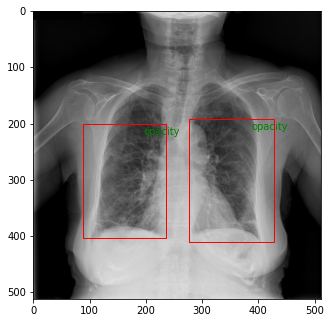

In [ ]:
# img, target = dataset_test.__getitem__(1)
# print(target)
for i in range(1):
  view_gt(dataset_test, i)

**To predict on one image given path**

In [ ]:
# loader uses the transforms function that comes with torchvision
loader = transforms.Compose([
    transforms.ToTensor()])  

unloader = transforms.ToPILImage()


# Enter the picture address
# Return tensor variable
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image)#.unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
###function to view gt bboxes
def view_gt_image(gt_path, img_path):
  '''
  function takes in a path to gt csv, an path to image
  '''
  gt = pd.read_csv(gt_path)
  #img, target = dataset_test.__getitem__(idx)
  #print(target)
  #img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
  #img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
  #img = np.array(img)  # tensor → ndarray
  img = Image.open(img_path)
  imgname = img_path.split("/")[-1]
  imgname = imgname.split(".")[0]
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  plt.imshow(img, cmap='gray')
  targets = {"boxes":[]}
  for _,row in gt[gt.id == imgname].iterrows():
  
    if row["class"] == "opacity":
      xmin = row.xmin
      ymin = row.ymin
      xmax = row.xmax
      ymax = row.ymax
      targets["boxes"].append([xmin,ymin,xmax,ymax])
         
      width = xmax - xmin
      height = ymax - ymin
      # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=8)
      # cv2.putText(img, 'opacity', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
      #                    thickness=2)
      edgecolor = 'r'
      ax.annotate('opacity' , xy=(xmax-40,ymin+20), color = 'g')
          
      # add bounding boxes to the image
      rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
      
      ax.add_patch(rect)
  return targets



Load saved model weights

In [ ]:
num_classes=2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model =  torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)  # Or get_object_detection_model(num_classes)
weights_path = r'/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/Faster_RCNN/Faster_RCNN_ResNet50_5.pkl'
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

<All keys matched successfully>

Function to view the image predictions and ground truths side-by-side for visualization. Can specify confidence threshold

In [ ]:
def comparison(model, img_path, gt_path, threshold):
     # The img entered is a tensor in the 0-1 range       
    img = image_loader(img_path) 
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1492.6672,  238.4670, 1765.5385,  315.0320],
        [ 887.1390,  256.8106, 1154.6687,  330.2953]], device='cuda:0'), 
        'labels': tensor([1, 1], device='cuda:0'), 
        'scores': tensor([1.0000, 1.0000], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])
        #prediction = utils.non_max_suppression(detections, 80, 0.3, 0.4)
        
    #print(prediction)
        
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    #fig = plt.subplot(1, 2, 1)#plt.figure()
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=1.0)
    #add axes to the image
    #ax = fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(121)
    plt.imshow(img) #, cmap='gray')
    
    for i in range(prediction[0]['boxes'].cpu().shape[0]):
        xmin = round(prediction[0]['boxes'][i][0].item())
        ymin = round(prediction[0]['boxes'][i][1].item())
        xmax = round(prediction[0]['boxes'][i][2].item())
        ymax = round(prediction[0]['boxes'][i][3].item())
        
        label = prediction[0]['labels'][i].item()
        score = round(prediction[0]['scores'][i].item(), 2)
        if score >= threshold:
          if label == 1:
                
                width = xmax - xmin
                height = ymax - ymin
                # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=8)
                # cv2.putText(img, 'opacity', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
                #                    thickness=2)
                edgecolor = 'r'
                ax.annotate('opacity ' + str(score), xy=(xmax-40,ymin+20), color = 'r')
                    
                # add bounding boxes to the image
                rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
                
    
                ax.add_patch(rect)
    gt = pd.read_csv(gt_path)

    img = Image.open(img_path)
    imgname = img_path.split("/")[-1]
    imgname = imgname.split(".")[0]
    #fig = plt.subplot(1, 2, 2)#plt.figure()
    #ax = fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(122)
    plt.imshow(img, cmap='gray')
    targets = {"boxes":[]}
    for _,row in gt[gt.id == imgname].iterrows():
    
      if row["class"] == "opacity":
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        targets["boxes"].append([xmin,ymin,xmax,ymax])
          
        width = xmax - xmin
        height = ymax - ymin
        # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), thickness=8)
        # cv2.putText(img, 'opacity', (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0),
        #                    thickness=2)
        edgecolor = 'r'
        ax.annotate('opacity' , xy=(xmax-40,ymin+20), color = 'r')
            
        # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
        
        ax.add_patch(rect)
    return prediction, targets


In [ ]:
dir = '/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/detection_training/images/valid/'
gt_path = r"/content/drive/Shareddrives/COVID-19_X-Ray/Project/SIIM_COVID-19_Data_512_PNG/df_ground_truth.csv"
threshold = 0.3


[{'boxes': tensor([[ 78.7229, 180.3639, 169.3270, 374.3095],
        [362.4962, 136.5992, 471.0857, 381.7949],
        [373.7895, 147.1788, 443.6498, 250.9783],
        [ 71.9926, 133.1911, 210.5587, 404.7965],
        [378.8840, 315.4049, 477.8442, 396.5411],
        [344.3341, 107.9199, 452.7734, 260.7977],
        [389.1585, 332.6046, 468.3174, 381.7761],
        [400.9162, 223.7075, 477.7052, 389.8862],
        [352.1896, 274.9662, 483.3995, 407.7280],
        [ 77.1935, 251.1179, 155.9415, 352.3141],
        [422.4322, 311.4102, 473.7324, 390.7985],
        [314.8163,  80.7456, 480.8328, 421.6398]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8424, 0.7860, 0.7743, 0.3590, 0.3524, 0.2747, 0.1558, 0.1391, 0.1305,
        0.0743, 0.0676, 0.0602], device='cuda:0')}]


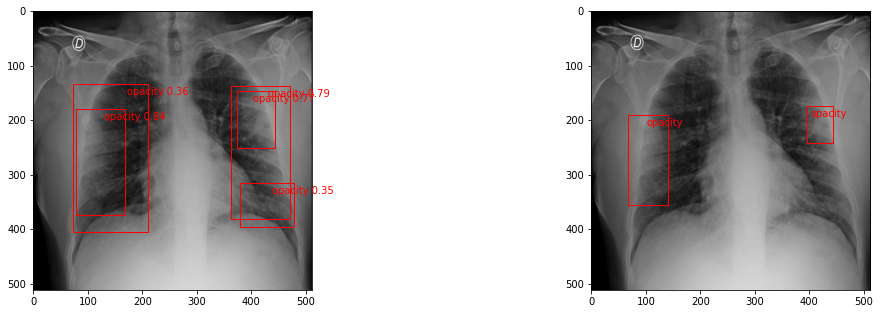

In [ ]:

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# im = image_loader(path)
# #####print(im.shape)
# #####pred = model(im)
# #####print(pred)
# showbbox(model, im)
# view_gt_image( gt_path, path)
i = 0
for img_name in os.listdir(dir):
  if i == 1:
    break
  path = os.path.join(dir, img_name)
  prediction, _ =comparison(model, path, gt_path, threshold)##currently confidence threshold set to > 0.5, NOT >= like before
  print(prediction)
  i+= 1